In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">
  <td>
    <a href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Churn%20prediction%20for%20game%20developers%20using%20Google%20Analytics%204%20%28GA4%29%20and%20BigQuery%20ML%20Notebook&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fanalytics-componentized-patterns%2Fblob%2Fmaster%2Fgaming%2Fpropensity-model%2Fbqml%2Fbqml_ga4_gaming_propensity_to_churn.ipynb">
      <img src="https://cloud.google.com/images/products/ai/ai-solutions-icon.svg" alt="AI Platform Notebooks">Run on AI Platform Notebooks</a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/analytics-componentized-patterns/blob/master/gaming/propensity-model/bqml/bqml_ga4_gaming_propensity_to_churn.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

# Overview
This notebook shows you how you can train, evaluate, and deploy a propensity model in BigQuery ML to predict user retention on a mobile game, based on app measurement data from Google Analytics 4.

#### Propensity modeling in the mobile gaming industry
According to a [2019 study](https://gameanalytics.com/reports/mobile-gaming-industry-analysis-h1-2019) on 100K mobile games by the Mobile Gaming Industry Analysis, most mobile games only see a 25% retention rate for users after the first 24 hours, and any game "below 30% retention generally needs improvement". In light of this, using machine learning -- to identify the propensity that a user churn after day 1 -- can allow app developers to incentivize users at higher risk of churning to return.

To predict the propensity (a.k.a. likelihood) that a user will return vs churn, you can use classification algorithms, like logistic regression, XGBoost, neural networks, or AutoML Tables, all of which are available with BigQuery ML.

#### Propensity modeling in BigQuery ML
With BigQuery ML, you can train, evaluate and deploy our models directly within BigQuery using SQL, which saves time from needing to manually configure ML infrastructure. You can train and deploy ML models directly where the data is already stored, which also helps to avoid potential issues around data governance.

Using classification models that you train and deploy in BigQuery ML, you can predict propensity using the output of the models. The models outputs provide a probability score between 0 and 1.0 -- how likely the model predicts that the user will churn (1) or not churn (0).

Using the probability (propensity) scores, you can then, for example, target users who may not return on their own, but could potentially return if they are provided with an incentive or notification.

#### Not just churn -- propensity modeling for any behavior
Propensity modeling is not limited to predicting churn. In fact, you can calculate a propensity score for any behavior you may want to predict. For example, you may want to predict the likelihood a user will spend money on in-app purchases. Or, perhaps you can predict the likelihood of a user performing "stickier" behaviors such as adding and playing with friends, which could lead to longer-term retention and organic user growth. Whichever the case, you can easily modify this notebook to suit your needs, as the overall workflow will still be the same.

## Scope of this notebook

### Dataset

This notebook uses [this public BigQuery dataset](https://console.cloud.google.com/bigquery?p=firebase-public-project&d=analytics_153293282&t=events_20181003&page=table), contains raw event data from a real mobile gaming app called Flood It! ([Android app](https://play.google.com/store/apps/details?id=com.labpixies.flood), [iOS app](https://itunes.apple.com/us/app/flood-it!/id476943146?mt=8)). The [data schema](https://support.google.com/analytics/answer/7029846) originates from Google Analytics for Firebase, but is the same schema as [Google Analytics 4](https://support.google.com/analytics/answer/9358801); this notebook applies to use cases that use either Google Analytics for Firebase or Google Analytics 4 data.

Google Analytics 4 (GA4) uses an [event-based](https://support.google.com/analytics/answer/9322688) measurement model. Events provide insight on what is happening in an app or on a website, such as user actions, system events, or errors. Every row in the dataset is an event, with various characteristics relevant to that event stored in a nested format within the row. While Google Analytics logs many types of events already by default, developers can also customize the types of events they also wish to log.

Note that as you cannot simply use the raw event data to train a machine learning model, in this notebook, you will also learn the important steps of how to pre-process the raw data into an appropriate format to use as training data for classification models.

#### Using your own GA4 data?
If you are already using a Google Analytics 4 property, follow [this guide]((https://support.google.com/analytics/answer/9823238) to learn how to export your GA4 data to BigQuery. Once the GA4 data is in BigQuery, there will be two tables:

* `events_`
* `events_intraday_`

For this notebook, you can replace the table in the `FROM` clause in SQL queries with your `events_` table that is updated daily. The `events_intraday_` table contains streaming data for the current day.

Note that if you use your own GA4 data, you may need to slightly modify some of the scripts in this notebook to predict a different output behavior or the types events in the training data that are specific to your use case. 

#### Using data from other non-Google Analytics data collection tools?

While this notebook provides code based on a Google Analytics dataset, you can also use your own dataset from other non-Google Analytics data collection tools. The overall concepts and process of propensity modeling will be the same, but you may need to customize the code in order to prepare your dataset into the training data format described in this notebook.


### Objective and Problem Statement

The goal of this notebook is to provide an end-to-end solution for propensity modeling to predict user churn on GA4 data using BigQuery ML. Using the "Flood It!" dataset, based on a user's activity within the first 24 hrs of app installation, you will try various classification models to predict the propensity to churn (1) or not churn (0).

By the end of this notebook, you will know how to:
* Explore the export of Google Analytics 4 data on BigQuery
* Prepare the training data using demographic, behavioral data, and the label (churn/not-churn)
* Train classification models using BigQuery ML
* Evaluate classification models using BigQuery ML
* Make predictions on which users will churn using BigQuery ML
* Activate on model predictions

### Costs 

There is no cost associated with using the free version of Google Analytics and using the BigQuery Export feature. This tutorial uses billable components of Google Cloud Platform (GCP):

* BigQuery
* BigQuery ML

Learn about [BigQuery pricing](https://cloud.google.com/bigquery/pricing), [BigQuery ML
pricing](https://cloud.google.com/bigquery-ml/pricing) and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Setup

### PIP Install Packages and dependencies

In [ ]:
!pip install google-cloud-bigquery

In [ ]:
# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

### Set up your GCP project

_The following steps are required, regardless of your notebook environment._

1. [Select or create a GCP project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

1. [Enable the AI Platform APIs and Compute Engine APIs.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component)

1. Enter your project ID and region in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

In [ ]:
PROJECT_ID = "polong-sandbox" #REPLACE WITH MY-PROJECT-ID
REGION = 'US'

### Import libraries and define constants

In [ ]:
from google.cloud import bigquery
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Create a BigQuery dataset

In this notebook, you will need to create a dataset in your project called `bqmlga4`. To create it, run the following cell:

In [ ]:
DATASET_NAME = "bqmlga4"
!bq mk --location=$REGION --dataset $PROJECT_ID:$DATASET_NAME

## The dataset

### Using the sample gaming event data from Flood it!



The sample dataset contains raw event data, as shown in the next cell:

_Note_: Jupyter runs cells starting with %%bigquery as SQL queries

In [ ]:
%%bigquery --project $PROJECT_ID

SELECT 
    *
FROM
  `firebase-public-project.analytics_153293282.events_*`
LIMIT 
  5

,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,user_properties,user_first_touch_timestamp,user_ltv,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions
0,20180812,1534062692517000,level_complete_quickplay,"[{'key': 'value', 'value': {'string_value': No...",1532908826237000,None,113,1182622,None,241293471505B5DFB907A2AFC5D26BC1,"[{'key': 'plays_quickplay', 'value': {'string_...",1473837406493000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'Japan', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193346,ANDROID,None
1,20180812,1534062807482019,level_complete_quickplay,"[{'key': 'value', 'value': {'string_value': No...",1534062674517019,None,113,1182622,None,241293471505B5DFB907A2AFC5D26BC1,"[{'key': 'plays_quickplay', 'value': {'string_...",1473837406493000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'Japan', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193346,ANDROID,None
2,20180812,1534062897722100,level_complete_quickplay,"[{'key': 'value', 'value': {'string_value': No...",1534062752482100,None,113,1182622,None,241293471505B5DFB907A2AFC5D26BC1,"[{'key': 'plays_quickplay', 'value': {'string_...",1473837406493000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'Japan', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193346,ANDROID,None
3,20180812,1534062613171001,screen_view,"[{'key': 'firebase_previous_id', 'value': {'st...",1534062600849001,None,112,891511,None,241293471505B5DFB907A2AFC5D26BC1,"[{'key': 'plays_quickplay', 'value': {'string_...",1473837406493000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'Japan', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193346,ANDROID,None
4,20180812,1534062681472006,screen_view,"[{'key': 'firebase_previous_id', 'value': {'st...",1534062602171006,None,112,891511,None,241293471505B5DFB907A2AFC5D26BC1,"[{'key': 'plays_quickplay', 'value': {'string_...",1473837406493000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'Japan', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193346,ANDROID,None


It may be helpful to take a look at the overall schema used in Google Analytics 4. As mentioned earlier, Google Analytics 4 uses an event based measurement model and each row in this dataset is an event. [Click here](https://support.google.com/analytics/answer/7029846) to view the complete schema and details about each column. As you can see above, certain columns are nested records and contain detailed information:



* `app_info`
* `device`
* `ecommerce`
* `event_params`
* `geo`
* `traffic_source`
* `user_properties`
* `items`*
* `web_info`*

_* present by default in GA4 datasets_

As we can see below, there are 15K users and 5.7M events in this dataset:

In [ ]:
%%bigquery --project $PROJECT_ID

SELECT 
    COUNT(DISTINCT user_pseudo_id) as count_distinct_users,
    COUNT(event_timestamp) as count_events
FROM
  `firebase-public-project.analytics_153293282.events_*`

,count_distinct_users,count_events
0,15175,5700000


### Preparing the training data

You cannot simply use raw event data to train a machine learning model as it would not be in the right shape and format to use as training data. So in this section, you will learn how to pre-process the raw data into an appropriate format to use as training data for classification models.


To predict which user is going to _churn_ or _return_, the ideal training data format for classification should look like the following:  


|User ID|User demographic data|User behavioral data|Label|
|-|-|-|-|
|User1|(e.g., country, device_type)|(e.g., # of times they did something within a time period)|1
|User2|(e.g., country, device_type)|(e.g., # of times they did something within a time period)|0
|User3|(e.g., country, device_type)|(e.g., # of times they did something within a time period)|1


Characteristics of the training data:
- each row is a separate unique user ID
- feature(s) for **demographic data**
- feature(s) for **behavioral data**
- the actual **label** that you want to train the model to predict (e.g., 1 = churned, 0 = returned)

You can train a model with only demographic data or behavioral data, but having a combination of both will likely help you create a more predictive model. For this reason, in this section, you will learn how to pre-process the raw data to follow this training data format.

The following sections will walk you through preparing the demographic data, behavioral data, and the label before joining them all together as the training data.

1. Identifying the label for each user (churned or returned)
1. Extracting demographic data for each user
1. Extracting behavioral data for each user
1. Combining the label, demographic and behavioral data together as training data

#### Step 1: Identifying the label for each user

The raw dataset doesn't have a feature that simply identifies users as "churned" or "returned", so in this section, you will need to create this label based on some of the existing columns.

There are many ways to define user churn, but for the purposes of this notebook, you will predict 1-day churn as users who do not come back and use the app again after 24 hr of the user's first engagement. 

In other words, after 24 hr of a user's first engagement with the app:
- if the user _shows no event data thereafter_, the user is considered **churned**. 
- if the user _does have at least one event datapoint thereafter_, then the user is considered **returned**

You may also want to remove users who were unlikely to have ever returned anyway after spending just a few minutes with the app, which is sometimes referred to as "bouncing". For example, we can say want to build our model only on users who spent at least 10 minutes with the app (users who didn't bounce).

So your updated definition of a **churned user** for this notebook is:
> "any user who spent at least 10 minutes on the app, but after 24 hour from when they first engaged with the app, never used the app again"


In SQL, since the raw data contains all of the events for every user, from their first touch (app installation) to their last touch, you can use this information to create two columns: `churned` and `bounced`.


Take a look at the following SQL query and the results:

In [ ]:
%%bigquery --project $PROJECT_ID 

CREATE OR REPLACE VIEW bqmlga4.returningusers AS (
  WITH firstlasttouch AS (
    SELECT
      user_pseudo_id,
      TIMESTAMP_MICROS(MIN(event_timestamp)) AS user_first_engagement,
      TIMESTAMP_MICROS(MAX(event_timestamp)) AS user_last_engagement
    FROM
      `firebase-public-project.analytics_153293282.events_*`
    WHERE event_name="user_engagement"
    GROUP BY
      user_pseudo_id

  )
  SELECT
    user_pseudo_id,
    user_first_engagement,
    user_last_engagement,

    #add 24 hr to user's first touch
    TIMESTAMP_ADD(user_first_engagement, INTERVAL 24 HOUR
                  ) AS ts_24hr_after_first_engagement,

#churned = 1 if last_touch within 24 hr of app installation, else 0
IF (user_last_engagement < TIMESTAMP_ADD(user_first_engagement, 
      INTERVAL 24 HOUR),
    1,
    0 ) AS churned,

#bounced = 1 if last_touch within 10 min, else 0
IF (user_last_engagement <= TIMESTAMP_ADD(user_first_engagement, 
      INTERVAL 10 MINUTE),
    1,
    0 ) AS bounced,
  FROM
    firstlasttouch
  GROUP BY
    1,2,3
    );

SELECT 
  * 
FROM 
  bqmlga4.returningusers 
LIMIT 10;

,user_pseudo_id,user_first_engagement,user_last_engagement,ts_24hr_after_first_engagement,churned,bounced
0,FC2DDF0F37BB211D565307010B1B30A1,2018-06-21 18:03:54.292001+00:00,2018-08-03 20:40:25.313123+00:00,2018-06-22 18:03:54.292001+00:00,0,0
1,5C5A0787542CD24F1E19F9EB778BA766,2018-06-13 16:14:29.620001+00:00,2018-09-29 08:52:07.746005+00:00,2018-06-14 16:14:29.620001+00:00,0,0
2,4BF98D09CA8359FC59ADAF56D00338F8,2018-06-14 21:28:59.007013+00:00,2018-10-03 11:53:28.966035+00:00,2018-06-15 21:28:59.007013+00:00,0,0
3,68EA8FDC3D7F8984530BB60FAE9A42FD,2018-06-21 03:37:47.418005+00:00,2018-10-02 20:23:10.382017+00:00,2018-06-22 03:37:47.418005+00:00,0,0
4,22DC6A6AE86C0AA33EBB8C3164A26925,2018-07-05 22:37:43.615005+00:00,2018-08-01 14:32:13.161027+00:00,2018-07-06 22:37:43.615005+00:00,0,0
5,1406751556EEDB1D112BF86CACAE9C88,2018-06-28 20:16:00.726007+00:00,2018-10-03 17:40:16.719023+00:00,2018-06-29 20:16:00.726007+00:00,0,0
6,BCD37BC09EFDBC9BEEE314EBBF815D01,2018-07-04 02:30:20.715008+00:00,2018-07-25 01:27:43.440003+00:00,2018-07-05 02:30:20.715008+00:00,0,0
7,75C683C1AE98FC6CCE6EA156C9E90A35,2018-07-06 07:35:49.659008+00:00,2018-07-19 14:48:49.517043+00:00,2018-07-07 07:35:49.659008+00:00,0,0
8,F99CC3598522ABE54B9DCAC2969179CC,2018-06-19 04:44:42.810004+00:00,2018-10-04 04:11:50.342066+00:00,2018-06-20 04:44:42.810004+00:00,0,0
9,E42E01EB4C3B845E6F61A6D09CA1051E,2018-06-24 00:09:19.617005+00:00,2018-07-18 02:16:25.859052+00:00,2018-06-25 00:09:19.617005+00:00,0,0


For the `churned` column, `churned=0` if the user performs an action after 24 hours since their first touch, otherwise if their last action was only within the first 24 hours, then `churned=1`.


For the `bounced` column, `bounced=1` if the user's last action was within the first ten minutes since their first touch with the app, otherwise `bounced=0`. We can use this column to filter our training data later on, by conditionally querying for users where `bounced = 0`.

You might wonder how many of these 15k users bounced and returned? You can run the following query to check:

In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
    bounced,
    churned, 
    COUNT(churned) as count_users
FROM
    bqmlga4.returningusers
GROUP BY 1,2
ORDER BY bounced

,bounced,churned,count_users
0,0,0,6148
1,0,1,1883
2,1,1,5557


For the training data, you will only end up using data where `bounced = 0`. Based on the 15k users, you can see that 5,557 (\~41%) users bounced within the first ten minutes of their first engagement with the app, but of the remaining 8,031 users, 1,883 users (\~23%) churned after 24 hours.

In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
    COUNTIF(churned=1)/COUNT(churned) as churn_rate
FROM
    bqmlga4.returningusers
WHERE bounced = 0

,churn_rate
0,0.234


#### Step 2. Extracting demographic data for each user

This section is focused on extracting the demographic information for each user. Different demographic information about the user is available in the dataset already, including `app_info`, `device`, `ecommerce`, `event_params`, `geo`. Demographic features can help the model predict whether users on certain devices or countries are more likely to churn.

For this notebook, you can start just with `geo.country`, `device.operating_system`, and `device.language`. If you are using your own dataset and have joinable first-party data, this section is a good opportunity to add any additional attributes for each user that may not be readily available in Google Analytics 4.

Note that a user's demographics may occasionally change (e.g. moving from one country to another). For simplicity, you will just use the demographic information that Google Analytics 4 provides when the user first engaged with the app as indicated by `MIN(event_timestamp)`. This enables every unique user to be represented by a single row.

In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_demographics AS (

  WITH first_values AS (
      SELECT
          user_pseudo_id,
          geo.country as country,
          device.operating_system as operating_system,
          device.language as language,
          ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp DESC) AS row_num
      FROM `firebase-public-project.analytics_153293282.events_*`
      WHERE event_name="user_engagement"
      )
  SELECT * EXCEPT (row_num)
  FROM first_values
  WHERE row_num = 1
  );

SELECT
  *
FROM
  bqmlga4.user_demographics
LIMIT 10

,user_pseudo_id,country,operating_system,language
0,015D5BB93CA7C81AE10106A8C39CB34B,United States,None,en-us
1,055922A1CAF55846CF969D475E41D35C,,ANDROID,en-us
2,055A7B424EBE798EB0318F3DBA55418C,Australia,IOS,en-gb
3,08358B40745104434E290F20296884E9,United States,IOS,en-us
4,091F09F594F7507A1D6D34D006A49CD9,United States,IOS,en-us
5,0A57BC0F6D09549CED636C498A541EF4,United States,IOS,en-us
6,0CE0108DD168AC70E11C9DD96C122956,Chile,ANDROID,es-ar
7,0F0B70C4BC8E1CC091E14227AE4038DE,United States,IOS,en-us
8,14CE6D01072B5345D007545B4B00A003,Egypt,ANDROID,en-gb
9,1587C99BC856418CCF3ABA3A9FA18673,Japan,IOS,ja-jp


#### Step 3. Extracting behavioral data for each user

Behavioral data in the raw event data spans across multiple events -- and thus rows -- per user. The goal of this section is to aggregate and extract behavioral data for each user, resulting in one row of behavioral data per unique user.

But what kind of behavioral data will you need to prepare? Since the end goal of this notebook is to predict, based on a user's activity within the first 24 hrs since app installation, whether that user will churn or return thereafter, then you will want to use behavioral data from the first 24 hrs in your training data. Later on, we can also extract some extra time-related features from `user_first_engagement`, such as the month or day of the first engagement.

Google Analytics automatically collects [certain events](https://support.google.com/analytics/answer/6317485) that you can use to analyze behavior. In addition, there are certain recommended [events for games](https://support.google.com/analytics/answer/6317494). 


As a first step, you can explore all the unique events that exist in this dataset, based on `event_name`:

In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
    event_name,
    COUNT(event_name) as event_count
FROM
    `firebase-public-project.analytics_153293282.events_*`
GROUP BY 1
ORDER BY
   event_count DESC

,event_name,event_count
0,screen_view,2247623
1,user_engagement,1358958
2,level_start_quickplay,523430
3,level_end_quickplay,349729
4,post_score,242051
5,level_complete_quickplay,191088
6,level_fail_quickplay,137035
7,level_reset_quickplay,122278
8,select_content,105139
9,level_start,74417


For this notebook, to predict whether a user will churn or return, you can start by counting the number of times a user engages in the following event types:

* `user_engagement`
* `level_start_quickplay`
* `level_end_quickplay`
* `level_complete_quickplay`
* `level_reset_quickplay`
* `post_score`
* `spend_virtual_currency`
* `ad_reward`
* `challenge_a_friend`
* `completed_5_levels`
* `use_extra_steps`



In SQL, you can aggregate the behavioral data by calculating the total number of times when each of the above `event_names` occurred in the data set per user.

If you are using your own dataset, you may have different event types that you can aggregate and extract. Your app may be sending very different `event_names` to Google Analytics so be sure to use events most suitable to your scenario.

In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_aggregate_behavior AS (
WITH
  events_first24hr AS (
    #select user data only from first 24 hr of using the app
    SELECT
      e.*
    FROM
      `firebase-public-project.analytics_153293282.events_*` e
    JOIN
      bqmlga4.returningusers r
    ON
      e.user_pseudo_id = r.user_pseudo_id
    WHERE
      TIMESTAMP_MICROS(e.event_timestamp) <= r.ts_24hr_after_first_engagement
    )
SELECT
  user_pseudo_id,
  SUM(IF(event_name = 'user_engagement', 1, 0)) AS cnt_user_engagement,
  SUM(IF(event_name = 'level_start_quickplay', 1, 0)) AS cnt_level_start_quickplay,
  SUM(IF(event_name = 'level_end_quickplay', 1, 0)) AS cnt_level_end_quickplay,
  SUM(IF(event_name = 'level_complete_quickplay', 1, 0)) AS cnt_level_complete_quickplay,
  SUM(IF(event_name = 'level_reset_quickplay', 1, 0)) AS cnt_level_reset_quickplay,
  SUM(IF(event_name = 'post_score', 1, 0)) AS cnt_post_score,
  SUM(IF(event_name = 'spend_virtual_currency', 1, 0)) AS cnt_spend_virtual_currency,
  SUM(IF(event_name = 'ad_reward', 1, 0)) AS cnt_ad_reward,
  SUM(IF(event_name = 'challenge_a_friend', 1, 0)) AS cnt_challenge_a_friend,
  SUM(IF(event_name = 'completed_5_levels', 1, 0)) AS cnt_completed_5_levels,
  SUM(IF(event_name = 'use_extra_steps', 1, 0)) AS cnt_use_extra_steps,
FROM
  events_first24hr
GROUP BY
  1
  );

SELECT
  *
FROM
  bqmlga4.user_aggregate_behavior
LIMIT 10

,user_pseudo_id,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,cnt_spend_virtual_currency,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps
0,532579121C1D62C00E6B3BE1108B2945,22,1,0,0,0,4,0,0,0,0,0
1,1EBC6E050F13EC1E1CED5CE91A2757BF,22,5,4,0,0,0,0,0,0,0,0
2,D7999E9077E211E50458765BCFF24C82,48,10,3,0,5,4,2,0,2,0,2
3,B082C1AA996253D2D7A753ACA6DD5364,9,0,0,0,0,2,0,0,0,0,0
4,8D9C05A55BA5E45A83F5A8605E6AF594,112,3,1,0,0,20,2,0,0,1,2
5,E0C192FB3648443D1356D1131049E433,8,1,1,0,0,0,0,0,0,0,0
6,D30416401803E77047A3EECF403914AD,10,3,3,2,0,2,0,0,0,0,0
7,343EF0B5FF277FA9F30E341F74048B07,41,10,6,3,1,3,7,0,0,0,7
8,9787443E5B9175CD412E316DEB1360CD,41,0,0,0,0,9,0,0,0,1,0
9,E510BBD42F7812869C5A623173026664,11,0,0,0,0,3,0,0,0,0,0


Note that in addition to frequency of performing an action, you can also include other behavioral features in this step such as the total amount of in-game currency they spent, or if they reached certain app-specifc milestones that may be more relevant to your app (e.g., gained a certain threshold amount of XP or leveled up at least 5 times). This is an opportunity for you to extend this notebook to suit your needs.

#### Step 4: Combining the label, demographic and behavioral data together as training data

In this section, you can now combine these three intermediary views (label, demographic, and behavioral data) into the final training data. Here you can also specify `bounced = 0`, in order to limit the training data only to users who did not "bounce" within the first 10 minutes of using the app.

In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.train AS (
    
  SELECT
    dem.*,
    IFNULL(beh.cnt_user_engagement, 0) AS cnt_user_engagement,
    IFNULL(beh.cnt_level_start_quickplay, 0) AS cnt_level_start_quickplay,
    IFNULL(beh.cnt_level_end_quickplay, 0) AS cnt_level_end_quickplay,
    IFNULL(beh.cnt_level_complete_quickplay, 0) AS cnt_level_complete_quickplay,
    IFNULL(beh.cnt_level_reset_quickplay, 0) AS cnt_level_reset_quickplay,
    IFNULL(beh.cnt_post_score, 0) AS cnt_post_score,
    IFNULL(beh.cnt_spend_virtual_currency, 0) AS cnt_spend_virtual_currency,
    IFNULL(beh.cnt_ad_reward, 0) AS cnt_ad_reward,
    IFNULL(beh.cnt_challenge_a_friend, 0) AS cnt_challenge_a_friend,
    IFNULL(beh.cnt_completed_5_levels, 0) AS cnt_completed_5_levels,
    IFNULL(beh.cnt_use_extra_steps, 0) AS cnt_use_extra_steps,
    ret.user_first_engagement,
    ret.churned
  FROM
    bqmlga4.returningusers ret
  LEFT OUTER JOIN
    bqmlga4.user_demographics dem
  ON 
    ret.user_pseudo_id = dem.user_pseudo_id
  LEFT OUTER JOIN 
    bqmlga4.user_aggregate_behavior beh
  ON
    ret.user_pseudo_id = beh.user_pseudo_id
  WHERE ret.bounced = 0
  );

SELECT
  *
FROM
  bqmlga4.train
LIMIT 10

,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,cnt_spend_virtual_currency,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps,user_first_engagement,churned
0,A72750663D0181C7817F61B3DD2CA656,United States,IOS,en-us,8,3,2,1,0,1,0,0,0,0,0,2018-08-02 06:13:19.940004+00:00,0
1,102CC7D8CD5D3E861EACE1BAB97E61EC,United States,ANDROID,en-us,34,13,11,11,0,11,2,1,0,0,2,2018-06-14 14:21:48.795004+00:00,0
2,5217AB1A454DAED6243E1C9818BE6A20,United States,ANDROID,en-us,89,0,0,0,0,27,0,0,0,1,1,2018-06-24 17:32:03.949001+00:00,0
3,1B959D672ABAE4A3BFB9D720D415E064,United States,ANDROID,en-us,135,0,0,0,0,19,1,0,0,1,1,2018-08-04 20:39:29.321007+00:00,0
4,3883FF0DFAB40ECD4EA781FC0D1CE18A,United States,ANDROID,en-us,114,32,29,9,0,9,0,0,0,0,0,2018-08-22 22:39:09.368003+00:00,0
5,56A24F4F7FE20C66839EB77FC558A160,United States,ANDROID,en-us,5,0,0,0,0,0,0,0,0,0,0,2018-06-26 21:19:23.137001+00:00,0
6,88A41BFED275BB69125BE1F5524F3B42,United States,ANDROID,en-us,5,2,1,0,0,1,0,0,0,0,0,2018-06-18 12:33:57.353004+00:00,0
7,5A619C1ED58AABE3A689326F95C63707,Netherlands,ANDROID,nl-nl,1,0,0,0,0,0,0,0,0,0,0,2018-08-01 11:06:45.805003+00:00,0
8,764B8932F53129D15854A1A12393513C,South Africa,ANDROID,en-za,35,0,0,0,0,13,0,0,0,1,0,2018-08-25 18:12:24.999001+00:00,1
9,E659018965C45C6546EAC732D07DABB3,United States,ANDROID,en-us,175,23,16,6,6,22,0,0,0,1,0,2018-08-24 22:20:11.893002+00:00,0


## Training the propensity model with BigQuery ML

In this section, using the training data you prepared, you will now train machine learning models in SQL using BigQuery ML. The remainder of the notebook will only use logistic regression, but you can also follow the optional code below to train other model types.

**Choosing the model:**
As this is a binary classification task, for simplicity, you can start with [logistic regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create), but you can also train other classification models like [XGBoost](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree), [deep neural networks](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-dnn-models) and [AutoML Tables](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-automl) in BigQuery ML to calculate propensity scores. Each of these models will output a probability score (propensity) between 0 and 1.0 of how likely the model prediction is based on the training data. In this notebook, the model predicts whether the user will churn (1) or return (0) after 24 hours of the user's first engagement with the app.


|Model| model_type| Advantages | Disadvantages|
|-|-|-|-|
|**Logistic Regression**| `LOGISTIC_REG` ([documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create))| Fast to train vs. other model types | May not have the highest model performance |
|**XGBoost**| `BOOSTED_TREE_CLASSIFIER` ([documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree))| Higher model performance. Can inspect feature importance. | Slower to train vs. `LOGISTIC_REG`.|
|**Deep Neural Networks**| `DNN_CLASSIFIER` ([documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-dnn-models))| Higher model performance | Slower to train vs. `LOGISTIC_REG`.|
|**AutoML Tables**| `AUTOML_CLASSIFIER` ([documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-automl))| Very high model performance | May take at least a few hours to train, not easy to explain how the model works. |


**There's no need to split your data into train/test:**
- When you run the `CREATE MODEL` statement, BigQuery ML will automatically split your data into training and test, so you can evaluate your model immediately after training (see the [documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#data_split_method) for more information or how to specify the split manually).


**Hyperparameter tuning:**
Note that you can also tune hyperparameters for each model, although it is beyond the scope of this notebook. See the [BigQuery ML documentation for CREATE MODEL](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create) for further details on the available hyperparameters.

**`TRANSFORM()`:** 
It may also be useful to extract features from datetimes/timestamps as one simple example of additional feature preprocessing before training. For example, we can extract the month, day of year, and day of week from `user_first_engagement`.  [`TRANSFORM()`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#transform) allows the model to remember the extracted values so you won't need to extract them again when making predictions using the model later on.

#### Train a logistic regression model

The following code trains a logistic regression model. This should only take a minute or two to train.

For more information on the default hyperparameters used, you can read the documentation:  
[CREATE MODEL statement](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create)

In [ ]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL bqmlga4.churn_logreg

TRANSFORM(
  EXTRACT(MONTH from user_first_engagement) as month,
  EXTRACT(DAYOFYEAR from user_first_engagement) as julianday,
  EXTRACT(DAYOFWEEK from user_first_engagement) as dayofweek,
  * EXCEPT(user_first_engagement, user_pseudo_id)
)

OPTIONS(
  MODEL_TYPE="LOGISTIC_REG",
  INPUT_LABEL_COLS=["churned"]
) AS

SELECT
  *
FROM
  bqmlga4.train

""


#### Train an XGBoost model (optional)

The following code trains an XGBoost model. This may take several minutes to train.

For more information on the default hyperparameters used, you can read the documentation:  
[CREATE MODEL statement for Boosted Tree models using XGBoost](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree)

In [ ]:
# %%bigquery --project $PROJECT_ID

# CREATE OR REPLACE MODEL bqmlga4.churn_xgb

# TRANSFORM(
#   EXTRACT(MONTH from user_first_engagement) as month,
#   EXTRACT(DAYOFYEAR from user_first_engagement) as julianday,
#   EXTRACT(DAYOFWEEK from user_first_engagement) as dayofweek,
#   * EXCEPT(user_first_engagement, user_pseudo_id)
# )

# OPTIONS(
#   MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
#   INPUT_LABEL_COLS=["churned"]
# ) AS

# SELECT
#   * EXCEPT(user_pseudo_id)
# FROM
#   bqmlga4.train

#### Train a deep neural network (DNN) model  (optional)

The following code trains a deep neural network. This may take several minutes to train.

For more information on the default hyperparameters used, you can read the documentation:  
[CREATE MODEL statement for Deep Neural Network (DNN) models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-dnn-models)

In [ ]:
# %%bigquery --project $PROJECT_ID

# CREATE OR REPLACE MODEL bqmlga4.churn_dnn

# TRANSFORM(
#   EXTRACT(MONTH from user_first_engagement) as month,
#   EXTRACT(DAYOFYEAR from user_first_engagement) as julianday,
#   EXTRACT(DAYOFWEEK from user_first_engagement) as dayofweek,
#   * EXCEPT(user_first_engagement, user_pseudo_id)
# )

# OPTIONS(
#   MODEL_TYPE="DNN_CLASSIFIER",
#   INPUT_LABEL_COLS=["churned"]
# ) AS

# SELECT
#   * EXCEPT(user_pseudo_id)
# FROM
#   bqmlga4.train

### Train an AutoML Tables model  (optional)

[AutoML Tables](https://cloud.google.com/automl-tables) enables you to automatically build state-of-the-art machine learning models on structured data at massively increased speed and scale. AutoML Tables automatically searches through Google’s model zoo for structured data to find the best model for your needs, ranging from linear/logistic regression models for simpler datasets to advanced deep, ensemble, and architecture-search methods for larger, more complex ones.

You can train an [AutoML model directly with BigQuery ML](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-automl), as in the code below.

Note that the `BUDGET_HOURS` parameter is for AutoML Tables training, specified in hours. The default value is 1.0 hour and must be between 1.0 and 72.0. The total query processing time can be greater than the budgeted hours specified in the query.

**Note:** This may take a few hours to train.


In [ ]:
# %%bigquery --project $PROJECT_ID

# CREATE OR REPLACE MODEL bqmlga4.churn_automl

# OPTIONS(
#   MODEL_TYPE="AUTOML_CLASSIFIER",
#   INPUT_LABEL_COLS=["churned"],
#   BUDGET_HOURS=1.0
# ) AS

# SELECT
#   * EXCEPT(user_pseudo_id)
# FROM
#   bqmlga4.train

## Model Evaluation

To evaluate the model, you can run [`ML.EVALUATE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate) on a model that has finished training to inspect some of the metrics.

The metrics are based on the test sample data that was automatically split during model creation ([documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#data_split_method)).

In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL bqmlga4.churn_logreg)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.480,0.034,0.768,0.063,0.515,0.667


`ML.EVALUATE` generates the `precision`, `recall`, `accuracy` and `f1_score` using the default classification threshold of 0.5, which can be modified by using the optional [`THRESHOLD`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate#eval_threshold) parameter.

Generally speaking, you can use the `log_loss` and `roc_auc` metrics to compare  model performance.

The `log_loss` ranges between 0 and 1.0, and the closer the `log_loss` is the zero, the closer the predicted labels were to the actual labels.
The `roc_auc` ranges between 0 and 1.0, and the closer the `roc_auc` is to 1.0, the better the model is at distinguishing between the classes.

For more information on these metrics, you can read through the definitions on [precision and recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall), [accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy), [f1-score](https://en.wikipedia.org/wiki/F-score), [log_loss](https://en.wikipedia.org/wiki/Loss_functions_for_classification#Logistic_loss) and [roc_auc](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

#### Confusion matrix: predicted vs actual values

In addition to model evaluation metrics, you may also want to use a confusion matrix to inspect how well the model predicted the labels, compared to the actual labels.

With the rows indicating the actual labels, and the columns as the predicted labels, the resulting format for ML.CONFUSION_MATRIX for binary classification looks like:

| | Predicted_0 | Predicted_1|
|-|-|-|
|Actual_0| True Negatives | False Positives|
|Actual_1| False Negatives | True Positives|

For more information on confusion matrices, you can read through a detailed explanation [here](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative).

In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL bqmlga4.churn_logreg)

,expected_label,predicted_0,predicted_1
0,0,1177,13
1,1,346,12


#### ROC Curve

You can plot the AUC-ROC curve by using `ML.ROC_CURVE` to return the metrics for different threshold values for the model ([documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-roc)).

In [ ]:
%%bigquery df_roc --project $PROJECT_ID
SELECT * FROM ML.ROC_CURVE(MODEL bqmlga4.churn_logreg)

In [ ]:
df_roc

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.000000,0.162679,0.030457,34,18,573,175
1,0.016000,0.162679,0.030457,34,18,573,175
2,0.026313,0.162679,0.030457,34,18,573,175
3,0.041914,0.162679,0.030457,34,18,573,175
4,0.062723,0.162679,0.030457,34,18,573,175
...,...,...,...,...,...,...,...
99,0.649010,0.028708,0.003384,6,2,589,203
100,0.663772,0.019139,0.001692,4,1,590,205
101,0.751260,0.009569,0.000000,2,0,591,207
102,0.892194,0.000000,0.000000,0,0,591,209


Plot the AUC-ROC curve

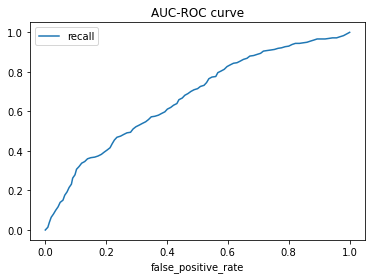

In [ ]:
df_roc.plot(x="false_positive_rate", y="recall", title="AUC-ROC curve")

## Model prediction

You can run [`ML.PREDICT`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict) to make predictions on the propensity to churn. The following code returns all the information from `ML.PREDICT`.

In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.PREDICT(MODEL bqmlga4.churn_logreg,
  (SELECT * FROM bqmlga4.train)) #can be replaced with a test dataset

,predicted_churned,predicted_churned_probs,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,cnt_spend_virtual_currency,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps,user_first_engagement,churned
0,0,"[{'label': 1, 'prob': 0.2737834589193487}, {'l...",295D9E24D8DE65A010313E667131EF19,Japan,ANDROID,ja-jp,135,5,5,2,0,20,3,0,0,1,3,2018-07-08 14:49:50.779006+00:00,0
1,0,"[{'label': 1, 'prob': 0.2604767612121717}, {'l...",B087A865A90AD52D1864A36482983BD2,United States,ANDROID,en-us,4,18,1,1,16,1,0,0,0,0,0,2018-08-14 19:56:49.893004+00:00,0
2,0,"[{'label': 1, 'prob': 0.17402203110280268}, {'...",ECC6975EB9808FBB45390E3EDB75B2A1,United States,ANDROID,en-us,2,0,0,0,0,0,0,0,0,0,0,2018-07-14 01:38:08.837000+00:00,0
3,0,"[{'label': 1, 'prob': 0.22145527544959154}, {'...",40E48F9F86A546EF73EDE7855625E2B2,Ecuador,ANDROID,en-us,44,5,4,2,0,9,2,0,0,1,2,2018-08-19 18:24:44.069001+00:00,0
4,0,"[{'label': 1, 'prob': 0.281488513554269}, {'la...",5E93985C5B02D9015C3326D060D2CD0B,United States,ANDROID,en-us,42,0,0,0,0,11,0,0,0,0,0,2018-08-25 18:22:06.431001+00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8026,0,"[{'label': 1, 'prob': 0.4779012136153148}, {'l...",8F41786DE39F9C50FFA0BC1E36CDB925,United States,None,en-us,124,48,47,0,1,34,0,0,0,0,0,2018-06-18 07:00:22.882007+00:00,1
8027,1,"[{'label': 1, 'prob': 0.5805115528749316}, {'l...",A8410038474DBDEEA7E94FE4E83C8984,India,None,en-in,18,3,0,0,1,0,0,0,0,0,0,2018-06-18 07:37:55.360002+00:00,1
8028,1,"[{'label': 1, 'prob': 0.6913664107433051}, {'l...",84F9AE2328F81708E2109489423BEAA9,Russia,ANDROID,ru-ru,34,7,7,1,0,1,0,0,2,0,0,2018-09-28 20:24:53.401003+00:00,1
8029,0,"[{'label': 1, 'prob': 0.39150408172775997}, {'...",085786B723B6CAEB0C616C4E8A1A6509,Canada,ANDROID,en-us,20,0,0,0,0,3,0,0,0,0,0,2018-09-28 14:28:00.151001+00:00,1


For propensity modeling, the most important output is the probability of a behavior occuring. The following query returns the probability that the user will return after 24 hrs. The higher the probability and closer it is to 1, the more likely the user is predicted to churn, and the closer it is to 0, the more likely the user is predicted to return.

In [ ]:
%%bigquery --project $PROJECT_ID

SELECT
  user_pseudo_id,
  churned,
  predicted_churned,
  predicted_churned_probs[OFFSET(0)].prob as probability_churned
  
FROM
  ML.PREDICT(MODEL bqmlga4.churn_logreg,
  (SELECT * FROM bqmlga4.train)) #can be replaced with a proper test dataset

,user_pseudo_id,churned,predicted_churned,probability_churned
0,026A3B2474E5012DE1D5B0C6BE6B5107,0,0,0.152
1,8119BA59B980089AA08263092A62B444,0,0,0.371
2,9556C9CA087D6F1F8CEEB93600B40C44,0,0,0.281
3,893526CD9E845D10C063B83B1C68D916,0,0,0.120
4,919364A97A32967836018EFB36C49ADA,0,0,0.119
...,...,...,...,...
8026,E85267BD443B8E106E9B90FB1E443AED,1,0,0.135
8027,B382EBE95FBB6251EF10D0DF76CE5E2B,1,0,0.167
8028,525D2BA85EFE112B955CD3B19909E059,1,1,0.545
8029,F74D98A3BB722F16D0E8D7434A4E0720,1,1,0.501


### Exporting the predictions out of Bigquery

##### Reading the predictions directly from BigQuery

With the predictions from `ML.PREDICT`, you can export the data into a Pandas dataframe using the BigQuery Storage API (see [documentation and code samples](https://cloud.google.com/bigquery/docs/bigquery-storage-python-pandas#download_table_data_using_the_client_library)). You can also use other [BigQuery client libraries](https://cloud.google.com/bigquery/docs/reference/libraries).

Alternatively you can also export directly into pandas in a notebook using the %%bigquery <variable name> as in:

In [ ]:
%%bigquery df --project $PROJECT_ID

SELECT
  user_pseudo_id,
  churned,
  predicted_churned,
  predicted_churned_probs[OFFSET(0)].prob as probability_churned
  
FROM
  ML.PREDICT(MODEL bqmlga4.churn_logreg,
  (SELECT * FROM bqmlga4.train)) #can be replaced with a proper test dataset

In [ ]:
df.head()

##### Export predictions table to Google Cloud Storage

There are several ways to export the predictions table to Google Cloud Storage (GCS), so that you can use them in a separate service. Perhaps the easiest way is to export directly to GCS using SQL ([documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/other-statements#export_data_statement)).

In [ ]:
%%bigquery --project $PROJECT_ID

EXPORT DATA OPTIONS (
uri="gs://mybucket/myfile/churnpredictions.csv", 
  format=CSV
) AS 
SELECT
  user_pseudo_id,
  churned,
  predicted_churned,
  predicted_churned_probs[OFFSET(0)].prob as probability_churned
FROM
  ML.PREDICT(MODEL bqmlga4.churn_logreg,
  (SELECT * FROM bqmlga4.train)) #can be replaced with a proper test dataset

## Activate on model predictions

Once you have the model predictions, there are different steps you can take based on your business objective.

In our analysis, we used `user_pseudo_id` as the user identifier. However, ideally, your app should send back the `user_id` from your app to Google Analytics. This will help you to:

* join any first-party data you have for model predictions
* joins the model predictions with your first-party data

Once you have this join capability, you can:

* Export the model predictions back into Google Analytics as user attribute. This can be done using [Data Import feature](https://support.google.com/analytics/answer/10071301) in Google Analytics 4.
    * Based on the prediction values you can [Create and edit audiences](https://support.google.com/analytics/answer/2611404) and also do [Audience targeting](https://support.google.com/optimize/answer/6283435). For example, an audience can be users with prediction probability between 0.4 and 0.7, to represent users who are predicted to be "on the fence" between churning and returning.
* Adjust the user experience for targeted users within your app. For Firebase Apps, you can use the [Import segmentments](https://firebase.google.com/docs/projects/import-segments) feature. You can tailor user experience by targeting your identified users through Firebase services such as Remote Config, Cloud Messaging, and In-App Messaging. This will involve importing the segment data from BigQuery into Firebase. After that you can send notifications to the users, configure the app for them, or follow the user journeys across devices.
* Run targeted marketing campaigns via CRMs like Salesforce, e.g. send out reminder emails.


## Further resources: 


As you collect more data from your users, you may want to regularly evaluate your model on fresh data and re-train the model if you notice that the model quality is decaying.

Continuous evaluation—the process of ensuring a production machine learning model is still performing well on new data—is an essential part in any ML workflow. Performing continuous evaluation can help you catch model drift, a phenomenon that occurs when the data used to train your model no longer reflects the current environment. 

To learn more about how to do continous model evaluation and re-train models, you can read the blogpost: [Continuous model evaluation with BigQuery ML, Stored Procedures, and Cloud Scheduler](https://cloud.google.com/blog/topics/developers-practitioners/continuous-model-evaluation-bigquery-ml-stored-procedures-and-cloud-scheduler)